<a href="https://colab.research.google.com/github/ishitamehta028/MLMapper/blob/main/MESSENGER_Mercury.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Mercury’s elemental composition from Albedo with MESSENGER Data
### **Ishita Mehta**


---



The maps provided have missing data and spatial resolution that varies depending on the latitude.

Areal coverage is variable for the different element-ratio maps, with 100% coverage for Mg/Si and Al/Si, but only 18% coverage for Fe/Si north of 30° N, where the spatial resolution is highest. 

As we approach the North pole of the planet (the top part), the quality of the image improves but we also encounter a lot of areas with missing data (the areas in purple). Conversely, as we get closer to the South pole (the bottom part) we see no missing data but the image quality deteriorates and the map starts looking blurry. There is a trade-off between high image resolution and the existence of data.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Text(0.5, 1.0, 'Bottom Half Mercury Albedo')

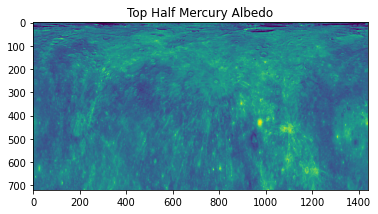

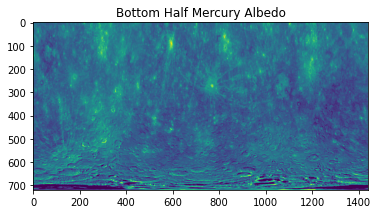

In [28]:
# reading datasets into dataframes 

top_albedo = pd.read_csv("/content/mercury-albedo-top-half.png.csv", header = None, sep=',')
bottom_albedo = pd.read_csv("/content/mercury-albedo-resized-bottom-half.png.csv", header = None, sep=',')


# Maps with element-ratios

Al_map = pd.read_csv("/content/alsimap_smooth_032015.png.csv", header = None, sep=',')     # Al/Si 
Ca_map = pd.read_csv("/content/casimap_smooth_032015.png.csv", header = None, sep=',')     # Ca/Si 
Fe_map = pd.read_csv("/content/fesimap_smooth_032015.png.csv", header = None, sep=',')     # Fe/Si 
Mg_map = pd.read_csv("/content/mgsimap_smooth_032015.png.csv", header = None, sep=',')     # Mg/Si 
S_map = pd.read_csv("/content/ssimap_smooth_032015.png.csv", header = None, sep=',')       # S/Si 

plt.figure()
plt.imshow(top_albedo, aspect = 'equal')
plt.title("Top Half Mercury Albedo")

plt.figure()
plt.imshow(bottom_albedo, aspect = 'equal')
plt.title("Bottom Half Mercury Albedo")

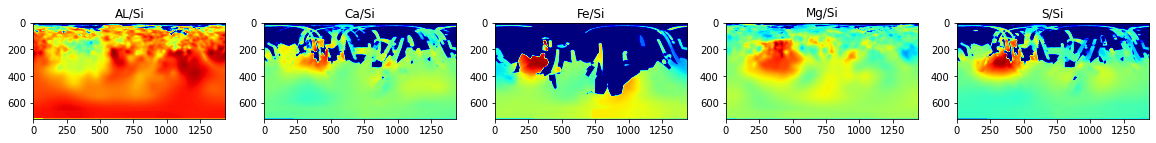

In [52]:
maps = [Al_map, Ca_map, Fe_map, Mg_map, S_map]
m = ['AL/Si', 'Ca/Si', 'Fe/Si', 'Mg/Si', 'S/Si']

fig, axis = plt.subplots(1, len(maps), figsize= (20,10))

for map in range(len(maps)) :
  axis[map].imshow(maps[map], cmap = 'jet')
  axis[map].set_title(str(m[map]))
  
plt.show()

In [64]:
if isinstance(top_albedo, pd.DataFrame):
  top_albedo = top_albedo.to_numpy()
if isinstance(bottom_albedo, pd.DataFrame):
  bottom_albedo = bottom_albedo.to_numpy()


[[0.48627451 0.49803922 0.52156866 ... 0.47843137 0.47450981 0.47450981]
 [0.48627451 0.49803922 0.52156866 ... 0.47843137 0.47450981 0.47450981]
 [0.02745098 0.01960784 0.01176471 ... 0.01960784 0.01960784 0.03137255]
 ...
 [0.31764707 0.36078432 0.40784314 ... 0.3137255  0.32941177 0.35294119]
 [0.32549021 0.35294119 0.39215687 ... 0.32549021 0.36078432 0.32549021]
 [0.32549021 0.35294119 0.39215687 ... 0.32549021 0.36078432 0.32549021]]


In [73]:
def create_dataset(albedo_ut, s_ut, fe_ut, al_ut, ca_ut, mg_ut):

  albedo = albedo_ut.reshape(-1, 1).squeeze().flatten()
  s = s_ut.reshape(-1, 1).squeeze().flatten()
  fe = fe_ut.reshape(-1, 1).squeeze().flatten()
  al = al_ut.reshape(-1, 1).squeeze().flatten()
  ca = ca_ut.reshape(-1, 1).squeeze().flatten()
  mg = mg_ut.reshape(-1, 1).squeeze().flatten()

  return np.array([albedo, s, fe, al, ca, mg])


mercury = (top_albedo, S_map, Fe_map, Al_map, Ca_map, Mg_map)

The highlighted areas in blue/purple show missing data. To overcome this proble, masking is used 

In [30]:
X_train_set ,y_train = dataframe(top_albedo, Al_map, Ca_map, Fe_map, Mg_map, S_map )
X_test_set, y_test = dataframe(bottom_albedo, Al_map, Ca_map , Fe_map, Mg_map, S_map )

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
715,0.003922,0.000000,0.000000,0.011765,0.027451,0.050980,0.078431,0.066667,0.047059,0.047059,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003922,0.007843,0.007843,0.007843,0.003922,0.000000,0.000000,0.000000,0.000000,0.0
717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003922,0.007843,0.007843,0.007843,0.003922,0.000000,0.000000,0.000000,0.000000,0.0
718,0.200000,0.203922,0.207843,0.219608,0.223529,0.231373,0.231373,0.235294,0.243137,0.250980,...,0.192157,0.192157,0.192157,0.192157,0.188235,0.188235,0.188235,0.192157,0.196078,0.2
719,0.200000,0.203922,0.207843,0.219608,0.223529,0.231373,0.231373,0.235294,0.243137,0.250980,...,0.192157,0.192157,0.192157,0.192157,0.188235,0.188235,0.188235,0.192157,0.196078,0.2


In [74]:
def eval(prediction) :
  eval = ['rmse', 'mse', 'r2score']
  error = []
  error.append(mean_squared_error(y_test, prediction))
  error.append(mean_absolute_error(y_test, prediction))
  error.append(r2_score(y_test, prediction)) 
  print("Error MSE, MAE, R2score : ",error, sep = '\n')

In [ ]:
def plot_prediction(pred) :
  prediction = pred.reshape(alb_r.shape)
  fig,a =  plt.subplots(1,2 , sharex='col', sharey='row' )
  plt.subplots_adjust()

# Y_test Data Albedo
  plt.subplot(1, 2, 1)
  plt.tight_layout()
  plt.imshow(alb_r)
  plt.title("True Albedo")

# Predicted Albedo
  plt.subplot(1, 2, 2)
  plt.imshow(prediction, cmap=plt.cm.get_cmap('PuBuGn',10))
  plt.title("Predicted Albedo")
  #sm = plt.cm.ScalarMappable(cmap = 'PuBuGn')
  #fig.colorbar(sm, orientation="horizontal")
  
  
# 1-D Histogrm plotted for Brightness of different pixels
  plt.figure()
  sns.distplot(pred, bins = 10, hist = True, color= 'yellow')
  sns.distplot(alb_r, color = 'green')
  plt.title('Brightness', fontweight="bold")
  plt.xlabel('Pixel Brightness', fontweight="bold")
  plt.ylabel('Pixel Count', fontweight="bold")
  plt.legend(['Predicted Albedo', 'True Albedo'])
  plt.show()
  
   

# Resdidual plot to show the difference of pixel intensities
  plt.figure()
  residual_plot = prediction - alb_r
  plt.imshow(residual_plot, cmap='Greys_r')
  plt.title('Residual Plot', fontweight = "bold")


In [ ]:
model = xgb.XGBRegressor(objective ='reg:squarederror', base_score = 0.5, learning_rate = 0.1, n_estimators = 30, eta= 0.2, max_depth = 6, alpha = 2)

# Training the model on the left side of the Moon
model.fit(X_train_set, y_train) 

#Predicting on the right side of the moon using the Chemical composition
prediction = model.predict(X_test_set) 
print("Predicted Albedo :", prediction)
eval(prediction)
plot_prediction(prediction)